In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import pandas as pd
import rdata
import csv
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import time

D:\Programme\Miniconda\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
def plot_images(images_list, labels):
    n = round(math.sqrt(len(images_list)))
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            axes[i, j].imshow(create_maldi_image(images_list[i*n+j]), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(labels[i*n+j])
    plt.savefig('plot.png')
    plt.show()
    
def create_maldi_image(spectra_list):
    # Get the dimensions of the image
    n = int(math.sqrt(len(spectra_list)))
    # Create an empty numpy array to store the maldi image
    maldi_image = np.zeros((n, n))
    
    # Loop over each pixel in the image and assign the corresponding spectra
    for row in range(n):
        for col in range(n):
            avg_value = np.sum(spectra_list[row * n + col]) / len(spectra_list[row * n + col])
            #maldi_image[row, col] = int(avg_value * 255)
            maldi_image[row, col] = np.round(avg_value * 255).astype(np.uint8)
            
    return maldi_image

In [3]:
def recursionStart(spectra):
    featurePairs = []
    maxima = []
    minima = []
    
    for i in range(1, len(spectra) - 1):
        if spectra[i] > spectra[i-1]:
            if spectra[i] >= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] > spectra[j]:
                        maxima.append([i, spectra[i]])
                        break
                    elif spectra[i] < spectra[j]:
                        break
        if spectra[i] < spectra[i-1]:
            if spectra[i] <= spectra[i+1]:
                for j in range(i+1, len(spectra)):
                    if spectra[i] < spectra[j]:
                        minima.append([i, spectra[i]])
                        break
                    elif spectra[i] > spectra[j]:
                        break
    maxima.sort(key = lambda element: element[1], reverse = True)
    minima.sort(key = lambda element: element[1])
    
    if len(maxima) == 0:
        return -1
    globalMaxima = maxima.pop(0)
    featurePairs.append([globalMaxima[0], globalMaxima[1] - minima[0][1]])
    
    recursionStep(0, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    recursionStep(len(spectra) - 1, globalMaxima[0], maxima.copy(), minima.copy(), featurePairs)
    
    return featurePairs

def recursionStep(start, end, maxima, minima, featurePairs):
    factor = 1
    if end < start:
        factor = -1
    currentMaxima = []
    for i in range(len(maxima)):
        position = maxima[i][0]
        if start * factor < position * factor and position * factor < end * factor:
            currentMaxima.append(maxima[i])
    if len(currentMaxima) == 0:
        return
    localMaxima = currentMaxima.pop(0)
    recursionStep(start, localMaxima[0], currentMaxima.copy(), minima.copy(), featurePairs)
    currentMinima = []
    for i in range(len(minima)):
        position = minima[i][0]
        if localMaxima[0] * factor < position * factor and position * factor < end * factor:
            currentMinima.append(minima[i])
    localMinima = currentMinima.pop(0)
    featurePairs.append([localMaxima[0], localMaxima[1] - localMinima[1]])
    recursionStep(localMinima[0], localMaxima[0], currentMaxima.copy(), currentMinima.copy(), featurePairs)
    recursionStep(localMinima[0], end, currentMaxima.copy(), currentMinima.copy(), featurePairs)
    
def getPersistenceTransformation_old(data_X, listOfK):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        
    spectrasForEachK = []
    
    for k in listOfK:
        transformationForSpectra = []
        for i in range(0, len(spectras)):
            transformation = [0] * len(data_X.iloc[i])
            featurePairs = spectras[i][0:round(k*len(spectras[i]))]
            for x, fx in featurePairs:
                transformation[x] = fx
            transformationForSpectra.append(transformation)
        spectrasForEachK.append(transformationForSpectra)
    return spectrasForEachK

def getPersistenceTransformationFixxed(data_X, number_of_peaks):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X.iloc[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
        

    transformationForSpectra = []
    for i in range(0, len(spectras)):
        transformation = [0] * len(data_X.iloc[i])
        if len(spectras[i]) == 1:
            k = 0
        else:
            k = number_of_peaks
        featurePairs = spectras[i][0:k]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    return transformationForSpectra

def getPersistenceTransformation(data_X):
    spectras = []
    for i in range(len(data_X)):
        featurePairs = recursionStart(data_X[i])
        if featurePairs == -1:
            spectras.append([[0,0]])
        else:
            featurePairs.sort(key = lambda element: element[1], reverse = True)
            spectras.append(featurePairs)
    return spectras
                
       
def getPercantageForSpectra(spectras, length, k):
    transformationForSpectra = []
    for i in range(0, len(spectras)):
        if len(spectras[i]) == 1:
            var_k = 0
        else:
            var_k = k
        transformation = [0] * length
        featurePairs = spectras[i][0:round(var_k*len(spectras[i]))]
        for x, fx in featurePairs:
            transformation[x] = fx
        transformationForSpectra.append(transformation)
    
    return transformationForSpectra

In [4]:
def read_data(path):
    parsed = rdata.parser.parse_file(path)
    converted = rdata.conversion.convert(parsed)
    data = np.array(list(converted.values()))[0]
    return data

def read_csv_data(path):
    # Read the CSV file
    #with open(path, "r") as csv_file:
    #    reader = csv.reader(csv_file)
    #    data = list(reader)

    # Convert the data to a NumPy array
    #np_data = np.array(data, dtype=float)

    # Print the NumPy array
    #return np_data
    
    # Load CSV file into NumPy array
    data = np.genfromtxt(path, delimiter=',', skip_header=1)
    return np.transpose(data[:, 1:])

In [5]:
def add_gaussian_noise(image, mean=0, std=1, seed=None):
    """Add Gaussian noise to a 2D numpy array."""
    if seed is not None:
        np.random.seed(seed)
    #noise = np.random.normal(mean, std, size=image.shape)
    noise = np.random.normal(loc=mean, scale=std, size=image.shape)
    return image + noise

def add_poisson_noise(matrix, lam=1, seed=None):
    """Add Poisson noise to a matrix.

    Args:
        matrix (numpy.ndarray): The matrix to add noise to.
        lam (float): The intensity parameter of the Poisson distribution.
        seed (int): The seed value for the random number generator.

    Returns:
        numpy.ndarray: The noisy matrix.

    """
    if seed is not None:
        np.random.seed(seed)

    noisy_matrix = np.random.poisson(lam=lam, size=matrix.shape)
    noisy_matrix = matrix + noisy_matrix.astype(np.float32)

    return noisy_matrix

def add_salt_noise(matrix, percentage):
    """
    Adds salt noise to a NumPy matrix.

    Parameters:
        matrix (np.ndarray): The matrix to add noise to.
        prob (float): The probability of a pixel being "salted".

    Returns:
        np.ndarray: The matrix with salt noise added.
    """
    # Create a copy of the matrix to modify
    noisy_matrix = np.copy(matrix)

    # Determine the number of pixels to salt
    num_pixels = int(percentage * len(matrix))

    # Generate a random set of indices for the pixels to salt
    indices = np.random.choice(len(matrix), size=num_pixels, replace=False)

    # Replace the pixels at the chosen indices with a high value (255)
    for ind in indices:
        for value in matrix[ind]:
            noisy_matrix[ind][int(value)] = 50.
    
    return noisy_matrix

def add_pepper_noise(matrix, percentage):
    """
    Adds pepper noise to a NumPy matrix.

    Parameters:
        matrix (np.ndarray): The matrix to add noise to.
        prob (float): The probability of a pixel being "peppered".

    Returns:
        np.ndarray: The matrix with pepper noise added.
    """
    # Create a copy of the matrix to modify
    noisy_matrix = np.copy(matrix)

    # Determine the number of pixels to pepper
    num_pixels = int(percentage * len(matrix))

    # Generate a random set of indices for the pixels to pepper
    indices = np.random.choice(len(matrix), size=num_pixels, replace=False)

    # Replace the pixels at the chosen indices with a low value (0)
    for ind in indices:
        for value in matrix[ind]:
            noisy_matrix[ind][int(value)] = 0.
    
    return noisy_matrix

In [6]:
def calculate_snr(image, noisy_image):
    """
    Calculates the signal-to-noise ratio (SNR) of an image given a noisy image.

    Parameters:
    -----------
    image : numpy array
        The original image.
    noisy_image : numpy array
        The image with added noise.

    Returns:
    --------
    snr : float
        The signal-to-noise ratio (SNR) in db
    """

    # Calculate the mean of the signal
    signal_mean = np.mean(image)

    # Calculate the mean of the noise
    noise_mean = np.mean(image - noisy_image)

    # Calculate the standard deviation of the noise
    noise_std = np.std(image - noisy_image)

    # Calculate the signal-to-noise ratio (SNR)
    snr = 10 * np.log10((signal_mean - noise_mean) / noise_std)

    return snr

In [44]:
def apply_pt(data, noise_type, k, lam = 0.1, mean = 0.1, std = 0.3, seed = 123, percentage = .05, baseline = 0):
    
    if noise_type == 'gaussian':
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        caption = 'Gaussian Noise,\nmean = {}, std = {}'.format(mean, std)
        save = 'gaussian_k_{}_mean_{}_std_{}_baseline_{}_size_{:.0f}x{:.0f}'.format(k, mean, std, baseline, math.sqrt(len(data)) ,math.sqrt(len(data)))
    elif noise_type == 'poisson':
        noisy_data = add_poisson_noise(data, lam = lam, seed=seed)
        caption = 'Poisson Noise,\nlam = {}'.format(lam)
        save = 'poisson_k_{}_lam_{}_baseline_{}_size_{:.0f}x{:.0f}'.format(k, lam, baseline, math.sqrt(len(data)) ,math.sqrt(len(data)))
    elif noise_type == 'salt':
        noisy_data = add_salt_noise(data, percentage)
        caption = 'Salt Noise,\npercantage = {}'.format(percentage)
        save='Unnamed'
    elif noise_type == 'pepper':
        noisy_data = add_salt_noise(data, percentage)
        caption = 'Pepper Noise,\npercantage = {}'.format(percentage)
        save='Unnamed'
    else:
        noisy_data = add_gaussian_noise(data, mean=mean, std=std, seed=seed)
        caption = 'Noise'
        save='Unnamed'
    
    st = time.time()
    pt_data = getPersistenceTransformation(data_X = noisy_data)
    et = time.time()   
    analyse_time = et - st
    
    pt_k = getPercantageForSpectra(pt_data, len(noisy_data[0]), k)
    
    img = create_maldi_image(data)
    img_noise = create_maldi_image(noisy_data)
    img_pt = create_maldi_image(pt_k)

    images = [img, img_noise, img_pt]
    
    snr = calculate_snr(img, img_noise)
    rmse_noise = np.sqrt(mean_squared_error(img, img_noise))
    rmse_pt = np.sqrt(mean_squared_error(img, img_pt))
    
    labels = ['Ground Truth\n Baseline = {}\nSize = {:.0f}x{:.0f}'.format(baseline, math.sqrt(len(data)), math.sqrt(len(data))), '{}\nsnr = {:.2f}, rsme = {:.2f}'.format(caption, snr, rmse_noise), 'Persistent Transformation\nk = {},\ntime = {:.0f} sec, rsme = {:.2f}'.format(k, analyse_time, rmse_pt)]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    for i in range(3):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(labels[i])
    plt.savefig('{}.png'.format(save))
    plt.show()

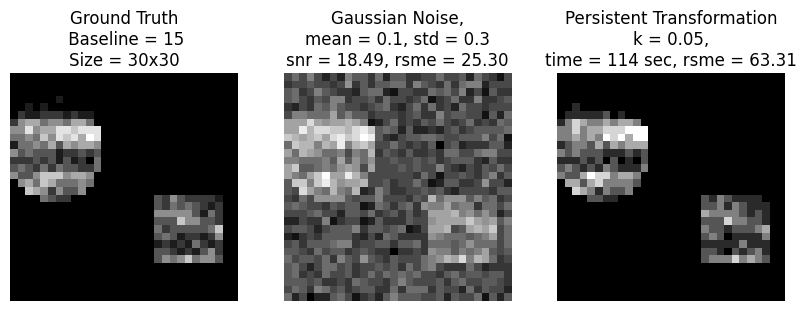

In [67]:
apply_pt(data = read_data("data/image_data_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 0.3, baseline = 15)

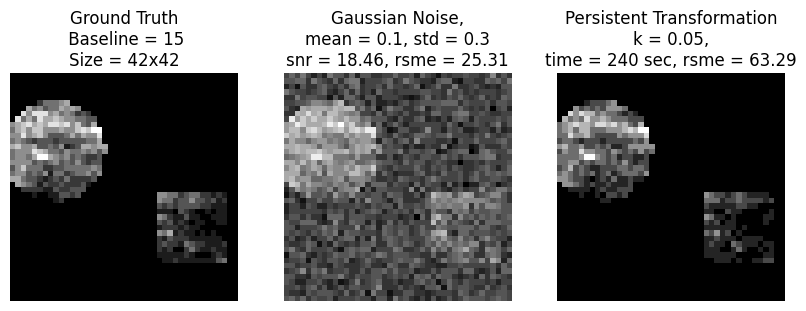

In [68]:
apply_pt(data = read_data("data/image_data_baseline_42x42_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 0.3, baseline = 15)

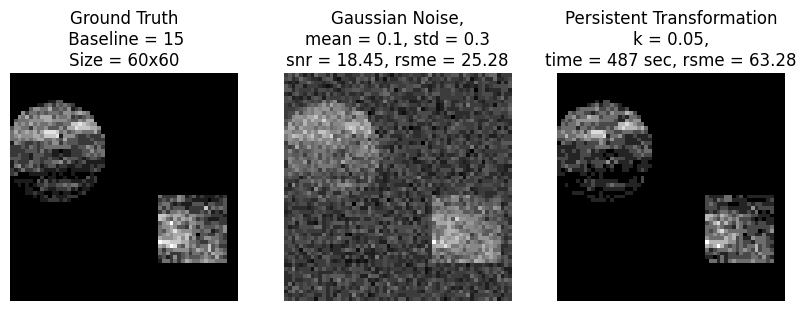

In [69]:
apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 0.3, baseline = 15)

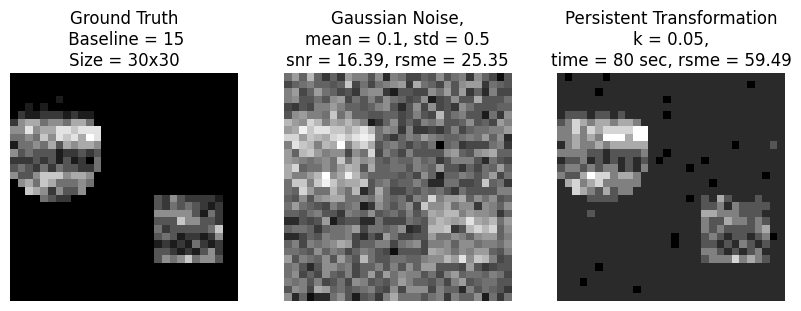

In [70]:
apply_pt(data = read_data("data/image_data_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 0.5, baseline = 15)

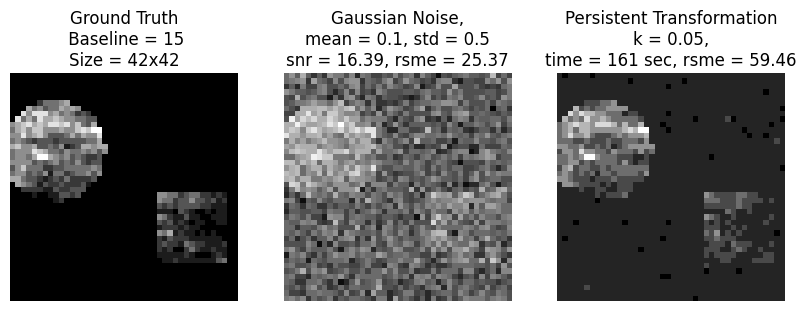

In [71]:
apply_pt(data = read_data("data/image_data_baseline_42x42_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 0.5, baseline = 15)

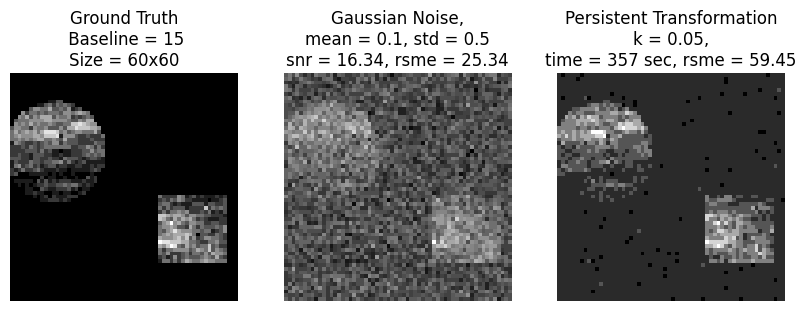

In [72]:
apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 0.5, baseline = 15)

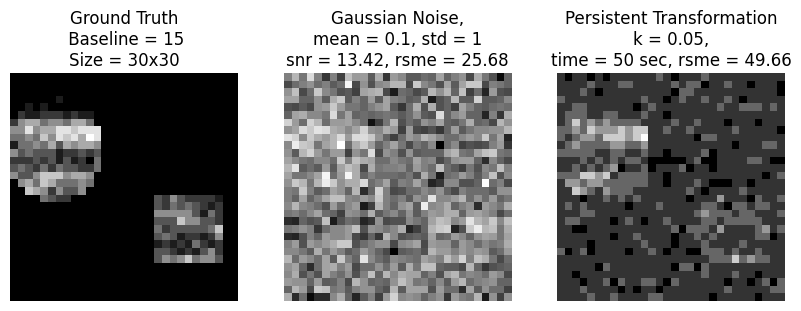

In [73]:
apply_pt(data = read_data("data/image_data_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 1, baseline = 15)

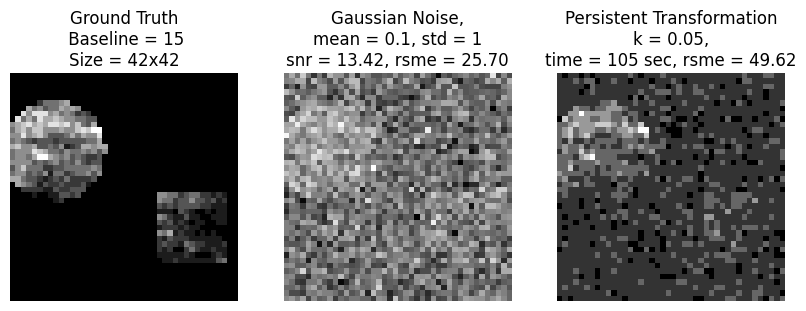

In [74]:
apply_pt(data = read_data("data/image_data_baseline_42x42_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 1, baseline = 15)

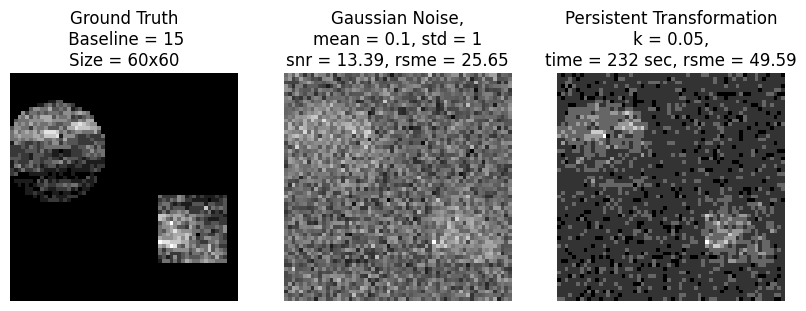

In [75]:
apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_15.RData"), noise_type = 'gaussian', k = 0.05, mean = 0.1, std = 1, baseline = 15)

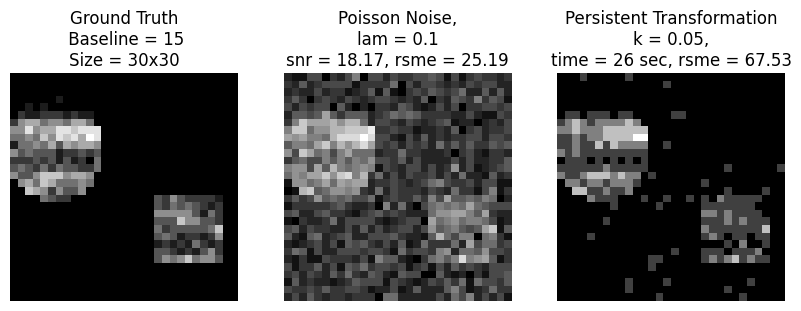

In [76]:
apply_pt(data = read_data("data/image_data_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.1, baseline = 15)

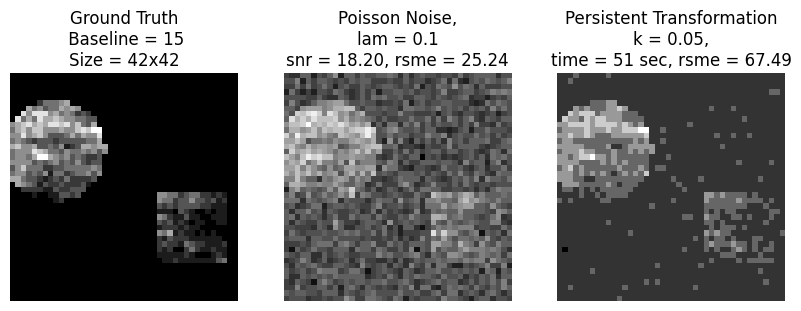

In [77]:
apply_pt(data = read_data("data/image_data_baseline_42x42_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.1, baseline = 15)

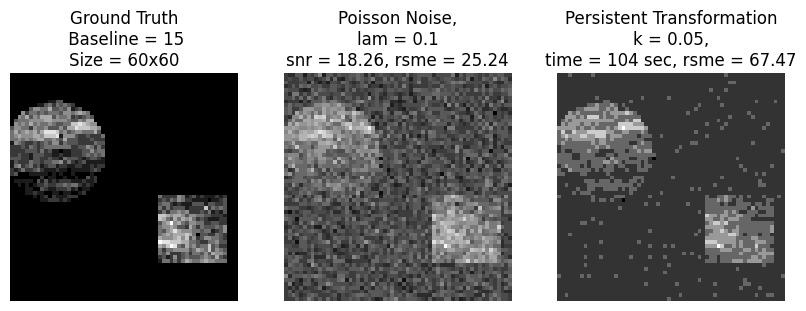

In [78]:
apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.1, baseline = 15)

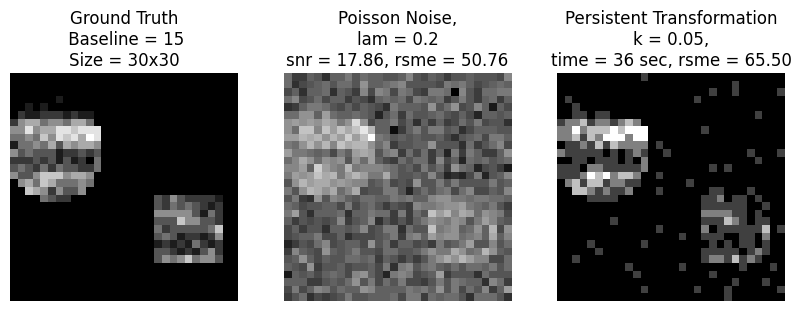

In [79]:
apply_pt(data = read_data("data/image_data_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.2, baseline = 15)

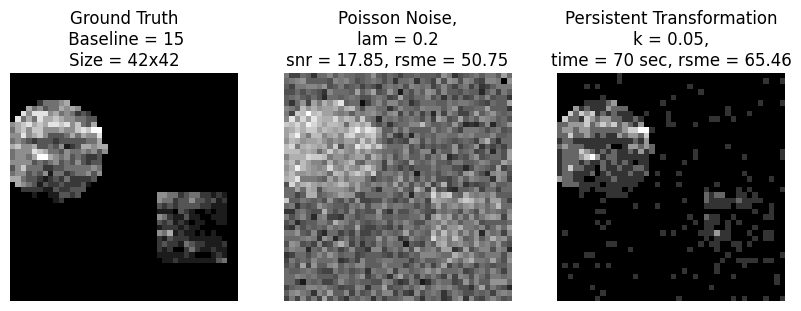

In [80]:
apply_pt(data = read_data("data/image_data_baseline_42x42_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.2, baseline = 15)

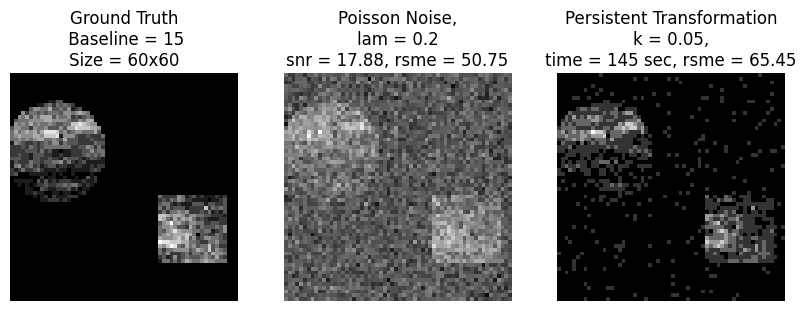

In [81]:
apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.2, baseline = 15)

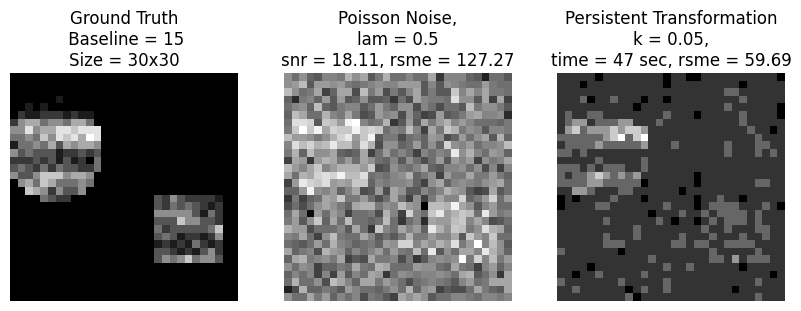

In [82]:
apply_pt(data = read_data("data/image_data_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.5, baseline = 15)

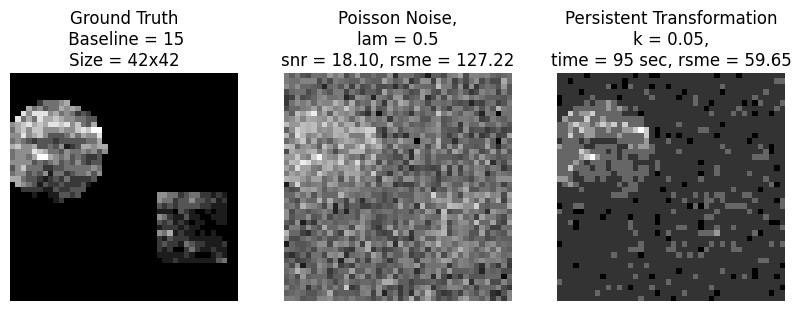

In [83]:
apply_pt(data = read_data("data/image_data_baseline_42x42_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.5, baseline = 15)

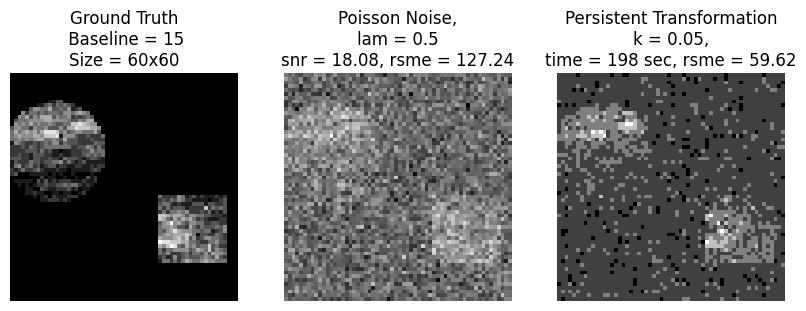

In [84]:
apply_pt(data = read_data("data/image_data_baseline_60x60_baseline_15.RData"), noise_type = 'poisson', k = 0.05, lam = 0.5, baseline = 15)